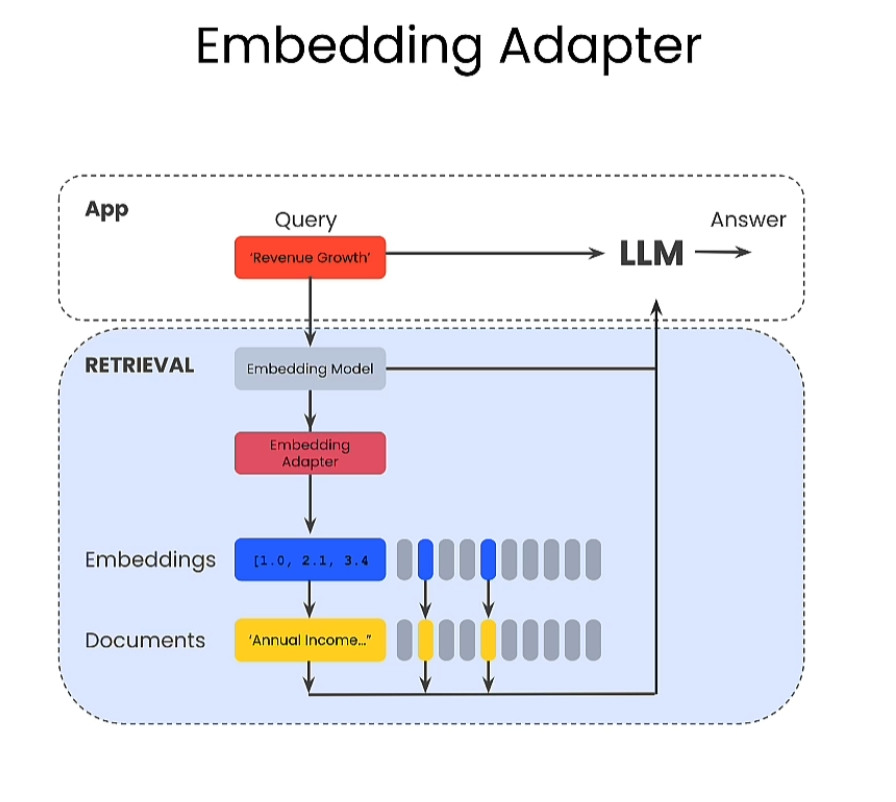

In [ ]:
!pip install openai==0.28

import openai

openai.api_key = "sk-xxx"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 2.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
embedding_adapter.py

This module provides a class for training an embedding adapter to fine-tune a pre-trained embedding model to
a specific document and retrieval task.
"""
from typing import Optional, Any

from pydantic import BaseModel
import numpy as np
import torch
from tqdm import tqdm

class EmbeddingAdapter(BaseModel):
    """
    A class for adapting embeddings to improve query-document matching.

    Attributes:
        _adapter (Optional[np.ndarray]): The adapter matrix.
        _embedding_len (Optional[int]): The length of the embeddings the adapter is trained on.
        _dataset (Optional[TensorDataset]): The dataset used for training the adapter.
    """
    _adapter: Optional[Any] = None
    _embedding_len: Optional[int] = None
    _dataset: Optional[Any] = None

    def _model(self, query_embedding, document_embedding, adapter_matrix):
        """
        The model function that applies the adapter matrix to the query embedding.

        Args:
            query_embedding (torch.Tensor): The query embedding.
            document_embedding (torch.Tensor): The document embedding.
            adapter_matrix (torch.Tensor): The adapter matrix.

        Returns:
            torch.Tensor: The cosine similarity between the updated query embedding and the document embedding.
        """
        updated_query_embedding = torch.matmul(adapter_matrix, query_embedding)
        return torch.cosine_similarity(updated_query_embedding, document_embedding, dim=0)

    def _mse_loss(self, query_embedding, document_embedding, adapter_matrix, label):
        """
        Calculates the mean squared error loss for the adapter training.

        Args:
            query_embedding (torch.Tensor): The query embedding.
            document_embedding (torch.Tensor): The document embedding.
            adapter_matrix (torch.Tensor): The adapter matrix.
            label (torch.Tensor): The target label.

        Returns:
            torch.Tensor: The mean squared error loss.
        """
        return torch.nn.MSELoss()(self._model(query_embedding, document_embedding, adapter_matrix), label)

    def fit(self, query_embedding, document_embedding, label, num_epochs: int = 100):
        """
        Trains the adapter matrix using the provided query embeddings, document embeddings, and labels.

        Args:
            query_embeddings (np.ndarray): An array of query embeddings.
            document_embeddings (np.ndarray): An array of document embeddings.
            labels (np.ndarray): An array of labels.

        Raises:
            ValueError: If the input arrays have mismatched lengths.
        """
        # Prepare the dataset
        adapter_query_embeddings = torch.Tensor(np.array(query_embedding))
        adapter_doc_embeddings = torch.Tensor(np.array(document_embedding))
        adapter_labels = torch.Tensor(np.expand_dims(np.array(label),1))
        self._dataset = torch.utils.data.TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

        # Initialize the training parameters
        min_loss = float('inf')
        best_matrix = None

        # Initialize the adapter matrix
        self._embedding_len = len(adapter_query_embeddings[0])
        adapter_matrix = torch.randn(self._embedding_len, self._embedding_len, requires_grad=True)

        # Train the adapter matrix
        for epoch in tqdm(range(num_epochs)):
            for query_embedding, document_embedding, label in self._dataset:
                loss = self._mse_loss(query_embedding, document_embedding, adapter_matrix, label)

                if loss < min_loss:
                    min_loss = loss
                    best_matrix = adapter_matrix.clone().detach().numpy()

                loss.backward()
                with torch.no_grad():
                    adapter_matrix -= 0.01 * adapter_matrix.grad
                    adapter_matrix.grad.zero_()

        print(f"Best loss: {min_loss.detach().numpy()}")

        self._adapter = best_matrix

    def transform(self, transform_embedding):
        """
        Transforms the given query embeddings using the trained adapter matrix.

        Args:
            transform_embedding (np.ndarray): The query embeddings to be transformed.

        Returns:
            np.ndarray: The transformed query embeddings.

        Raises:
            RuntimeError: If the adapter is not trained.
            ValueError: If the length of the embedding to transform does not match the adapter.
        """
        if self._adapter is None:
            raise RuntimeError("Adapter not trained")
        input_len = len(transform_embedding)
        if input_len != self._embedding_len:
            raise ValueError(f"Embedding to transform is of length {input_len}. Adapter was trained for embeddings of length {self._embedding_len}.")
        return np.matmul(self._adapter, np.array(transform_embedding).T).T

    def patch(self):
        """
        Returns a function that wraps around the original embedding function to apply the transformation.

        Returns:
            Any: A function that transforms embeddings using the trained adapter.
        """
        return self.transform

In [ ]:
# import numpy as np
# from transformers import AutoTokenizer, AutoModel
# import torch

# tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
# model = AutoModel.from_pretrained('bert-base-uncased')

# def get_embedding(text):
#     inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
#     outputs = model(**inputs)
#     return outputs.last_hidden_state.mean(dim=1).detach().numpy()

In [ ]:
def get_embedding(text):
    response = openai.Embedding.create(input=text, model="text-embedding-ada-002")
    return response['data'][0]['embedding']

In [ ]:
import json

file_path = '/content/BioASQ-train-yesno-11b.json'
with open(file_path, 'r') as file:
    data = json.load(file)

In [ ]:
# data

In [ ]:
# data2 = data['data']['paragraphs'][:5]

In [ ]:
# data2

In [ ]:
query_embeddings = []
document_embeddings = []
labels = []

for paragraph in data['data']["paragraphs"]:
    for qa in paragraph["qas"]:
        question_embedding = get_embedding(qa["question"])
        context_embedding = get_embedding(paragraph["context"])
        label = 1.0 if qa["answers"].lower() == "yes" else 0.0

        query_embeddings.append(question_embedding)
        document_embeddings.append(context_embedding)
        labels.append(label)

In [ ]:
query_embeddings = np.vstack(query_embeddings)
document_embeddings = np.vstack(document_embeddings)
labels = np.array(labels)

In [ ]:
# output_data = {
#     "query_embeddings": query_embeddings.tolist(),
#     "document_embeddings": document_embeddings.tolist(),
#     "labels": labels.tolist()
# }

# output_file_path = 'embeddings_openai.json'
# with open(output_file_path, 'w') as output_file:
#     json.dump(output_data, output_file)

In [ ]:
import json

with open('/content/drive/MyDrive/embeddings_openai.json', 'r') as file:
    data = json.load(file)

query_embeddings = data["query_embeddings"]
document_embeddings = data["document_embeddings"]
labels = data["labels"]

# print("Query Embeddings:", query_embeddings)
# print("Document Embeddings:", document_embeddings)
# print("Labels:", labels)

In [ ]:
adapter = EmbeddingAdapter()
adapter.fit(query_embeddings, document_embeddings, labels, num_epochs=30)

In [ ]:
transformed_embedding = adapter.transform(query_embeddings[0])
print(transformed_embedding)

## Using FAISS

In [ ]:
import faiss

texts = [item['context'] for item in data["data"]["paragraphs"]]

document_embeddings = []
for text in texts:
    embedding = adapter.transform(get_embedding(text))
    document_embeddings.append(embedding)

document_embeddings_np = np.array(document_embeddings)

# Create Faiss index with document embeddings
dimension = document_embeddings_np.shape[1]
index = faiss.IndexFlatIP(dimension)
index.add(document_embeddings_np)

def get_retrieved_documents(query, top_k=5):
    query_embedding = adapter.transform(get_embedding(query))

    _, similar_indices = index.search(np.array([query_embedding]), top_k)

    retrieved_documents = [texts[idx] for idx in similar_indices[0]]

    return retrieved_documents

def rag(query, retrieved_documents, model="gpt-4o"):
    information = "\n\n".join(retrieved_documents)

    messages = [
        {
            "role": "system",
            "content": "You are a knowledgeable healthcare research assistant. Your users are asking questions about information contained in a healthcare document. You will be shown the user's question and the relevant information from the healthcare document. Answer the question with support of the provided document."
        },
        {"role": "user", "content": f"Question: {query}. \n Information: {information}"}
    ]

    response = openai.ChatCompletion.create(
        model=model,
        messages=messages
    )

    content = response.choices[0].message["content"]
    return content

Streaming output truncated to the last 5000 lines.
Embedding shape for 'Cyclophosphamide and tocilizumab look promising but require validation in further studies. ': (768,)
Embedding shape for 'Therefore, tocilizumab (humanised monoclonal antibody binding the human interleukin-6 receptor) was introduced as a potential salvage therapy with a swift consecutive resolution of the systemic symptoms and stabilization of the ophthalmic lesions.CONCLUSIONS: Although a late effect of steroids pulses cannot be formally ruled out in this dramatic situation, tocilizumab likely offered a decisive effect in preventing bilateral blindness and may have contributed to steroid tapering. Tocilizumab may represent a new early effective second-line treatment option in corticosteroid-resistant anterior ischemic optic neuropathy. ': (768,)
Embedding shape for 'Tocilizumab for giant cell arteritis with corticosteroid-resistant progressive anterior ischemic optic neuropathy.': (768,)
Embedding shape for 'CONCL

In [ ]:
query = "Is the monoclonal antibody Trastuzumab (Herceptin) of potential use in the treatment of prostate cancer?"
retrieved_documents = get_retrieved_documents(query=query)

output = rag(query=query, retrieved_documents=retrieved_documents)
print("Question:")
print(query)
print("\nAnswer:")
print(output)

Embedding shape for 'Is the monoclonal antibody Trastuzumab (Herceptin) of potential use in the treatment of prostate cancer?': (768,)
Question:
Is the monoclonal antibody Trastuzumab (Herceptin) of potential use in the treatment of prostate cancer?

Answer:
Based on the provided information, Trastuzumab (Herceptin) is a monoclonal antibody that targets the HER2 receptor and is specifically approved and useful for the treatment of HER2-positive breast cancer. There is no mention of its use in the treatment of prostate cancer within the provided information. Therefore, according to the given document, Trastuzumab (Herceptin) is not indicated for the treatment of prostate cancer.


## Using Pinecone

In [ ]:
!pip install pinecone-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 2.8 MB/s eta 0:00:00


In [ ]:
# paragraphs = data['data']['paragraphs']

In [ ]:
# paragraphs

In [ ]:
# from pinecone import Pinecone

# pc = Pinecone(api_key="32cdac1e-f2d9-420d-9616-c2fd4c35f0a5")
# index = pc.Index("biosqa")

In [ ]:
# index.upsert(
#     vectors=[
#         {
#             "id": "vec1",
#             "values": [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
#             "metadata": {"genre": "drama"}
#         }, {
#             "id": "vec2",
#             "values": [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
#             "metadata": {"genre": "action"}
#         }, {
#             "id": "vec3",
#             "values": [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3],
#             "metadata": {"genre": "drama"}
#         }, {
#             "id": "vec4",
#             "values": [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
#             "metadata": {"genre": "action", "tampan":"yes"}
#         }
#     ],
#     namespace= "ns1"
# )

{'upserted_count': 4}

In [ ]:
# def upsert_documents_and_embeddings(documents, embeddings, namespace):
#     for doc, embedding in zip(documents, embeddings):
#         for qa in doc["qas"]:
#             index.upsert(
#                 vectors=[{"id": qa["id"],
#                           "values": embedding,
#                           "metadata":{
#                           "context": doc["context"],
#                           "question": qa["question"],
#                           "is_impossible": qa["is_impossible"],
#                           "answer": qa["answers"]
#                           }
#                           }
#                          ],
#                 namespace=namespace
#             )


In [ ]:
# documents = [
#     {
#         "qas": [
#             {
#                 "id": qa["id"],
#                 "question": qa["question"],
#                 "is_impossible": qa["is_impossible"],
#                 "answers": qa["answers"]
#             }
#         ],
#         "context": paragraph["context"]
#     }
#     for paragraph in data["data"]["paragraphs"]
#     for qa in paragraph["qas"]
# ]

# namespace_to_use = "ns1"

# upsert_documents_and_embeddings(documents=documents, embeddings=document_embeddings, namespace=namespace_to_use)

In [ ]:
from pinecone import Pinecone

pc = Pinecone(api_key="")
index = pc.Index("")

In [ ]:
import openai
import json
from pinecone import Pinecone
import pandas as pd

In [ ]:
def get_retrieved_documents(query, top_k=5):
    query_embedding = adapter.transform(get_embedding(query)).tolist()
    result = index.query(
        vector=query_embedding,
        top_k=top_k,
        include_metadata=True
    )
    retrieved_documents = [match['metadata']['text'] for match in result['matches']]
    return retrieved_documents

df = pd.read_json('/content/BioASQ-test-yesno-rag-11b.json')

output_json = {
    'data': [
        {
            'paragraphs': [],
            'title': 'BioASQ11b'
        }
    ],
    'version': 'BioASQ11b'
}

for i in tqdm(df.index):
    query = df.loc[i, 'questions']
    id = df.loc[i, 'ids']

    retrieved_documents = get_retrieved_documents(query)
    context = '\n'.join(retrieved_documents)

    dct = {
        'qas': [
            {
                'id': f"{id}_001",
                'question': query
            }
        ],
        'context': context
    }
    output_json['data'][0]['paragraphs'].append(dct)

with open('output2-BioASQ-test-yesno-11b.json', 'w') as outfile:
    json.dump(output_json, outfile, indent=2)


100%|██████████| 618/618 [01:43<00:00,  6.00it/s]


In [ ]:
def get_retrieved_documents(query, top_k=5):
    query_embedding = adapter.transform(get_embedding(query)).tolist()
    result = index.query(
        vector=query_embedding,
        top_k=top_k,
        include_metadata=True
    )
    retrieved_documents = [match['metadata']['text'] for match in result['matches']]
    return retrieved_documents

def rag(query, retrieved_documents, model="gpt-4"):
    information = "\n\n".join(retrieved_documents)

    messages = [
        {
            "role": "system",
            "content": "You are a knowledgeable healthcare research assistant. Your users are asking questions about information contained in a healthcare document. You will be shown the user's question and the relevant information from the healthcare document. Answer the question with support of the provided document."
        },
        {"role": "user", "content": f"Question: {query}. \n Information: {information}"}
    ]

    response = openai.ChatCompletion.create(
        model=model,
        messages=messages
    )

    content = response.choices[0].message["content"]
    return content

In [ ]:
query = "Is the protein Papilin secreted?"
retrieved_documents = get_retrieved_documents(query, top_k=5)
print("Retrieved Documents:")
for doc in retrieved_documents:
    print(doc)

response = rag(query, retrieved_documents)
print("Generated Response:")
print(response)

In [ ]:
!git clone https://github.com/fadliaulawi/biobert-pytorch

Cloning into 'biobert-pytorch'...
remote: Enumerating objects: 277, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 277 (delta 46), reused 48 (delta 33), pack-reused 210
Receiving objects: 100% (277/277), 4.49 MiB | 9.33 MiB/s, done.
Resolving deltas: 100% (76/76), done.


In [ ]:
%cd biobert-pytorch/
# !bash ../download.sh
%cd question-answering/

/content/biobert-pytorch
/content/biobert-pytorch/question-answering


In [ ]:
!python run_yesno.py \
    --model_type bert \
    --model_name_or_path "dmis-lab/biobert-base-cased-v1.1-squad" \
    --do_train \
    --train_file "BioASQ-train-yesno-11b.json" \
    --per_gpu_train_batch_size 12 \
    --learning_rate 8e-6 \
    --num_train_epochs 3 \
    --max_seq_length 384 \
    --seed 0 \
    --output_dir "output/"

2024-06-09 05:35:38.402247: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 05:35:38.402300: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 05:35:38.403623: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-09 05:35:38.410618: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 05:35:39.591589: W tensorflow/comp

In [ ]:
!python run_yesno.py \
    --model_type bert \
    --model_name_or_path "dmis-lab/biobert-base-cased-v1.1-squad" \
    --do_eval \
    --predict_file "BioASQ-test-yesno-11b.json" \
    --golden_file "11B_golden.json" \
    --output_dir "output/"

2024-06-09 05:53:42.758667: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 05:53:42.758723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 05:53:42.760283: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-09 05:53:42.768214: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 05:53:44.071853: W tensorflow/comp